# Class 26:  Bayesian Networks
## Infer a Bayesian network from a matrix of discretized phospho-flow cytometry data.
### Based on supplementary data from the 2005 article by Karen Sachs et al. (Science v308, 2005). 

In this class exercise, we will use the fundamental theorem for the likelihood of a Bayesian network structure for categorical variables, in order to score the posterior probability of the network shown in the Sachs et al. article (Figure 3A) vs. the phospho-flow cytometry data that the same authors provided in their supplementary data. The phospho-flow cytometry data have been already discretized for you (see "class26_bayesnet_dataprep_R.ipynb").  We will need to implement a single-vertex log-likelihood function using Theorem 1 from the article by Cooper & Herskovits in *Machine Learning* (volume 9, pages 309-347, 1992).

Load the tab-delimited data file of discretized phosphoprotein expression data (12 columns; first 11 columns are the expression levels -- "low", "medium", "high"; last column is the experiment identifier for the row; there are nine experiments). Print out the first six lines of the data frame, so you can see what it looks like.

In [13]:
import pandas
g_discret_data = pandas.read_csv("shared/sachs_data_discretized.txt",
                                 sep="\t")
g_discret_data.head(n=6)

,praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk,expt
0,low,low,low,low,high,low,low,medium,medium,high,high,1_cd3cd28
1,low,low,medium,low,low,medium,medium,medium,low,low,high,1_cd3cd28
2,medium,high,medium,low,medium,medium,medium,medium,medium,medium,medium,1_cd3cd28
3,medium,high,medium,low,low,low,low,medium,medium,medium,medium,1_cd3cd28
4,low,medium,low,low,medium,medium,medium,low,low,medium,high,1_cd3cd28
5,low,low,medium,low,low,medium,medium,medium,medium,high,high,1_cd3cd28


Define a log likelihood function for the vertex degree distribution

In [359]:
import numpy

def log_prob_network_prior(network):
    degarray = numpy.sum(network, axis=0) + numpy.sum(network, axis=1)
    degarray_float = numpy.zeros(len(degarray))
    degarray_float[:] = degarray
    return numpy.sum(numpy.log(numpy.power(1.0 + degarray_float, -2)))

Define a vectorized log-factorial function, since it doesn't seem to be a builtin in python:

In [15]:
import scipy.special

def lfactorial(n):
    return scipy.special.gammaln(n+1)

Define a log likelihood function for a single vertex, based on Theorem 1 in the 1992 article in *Machine Learning* by Cooper & Herskovits. Note:  we are using igraph's adjacency matrix format which is the transpose of Newman's adjacency matrix definition!

In [373]:
import math

def log_likelihood_network_vertex(network, vertex, discret_data):
    # network is a NxN numpy matrix (N = 11 vertices)
    # vertex is an integer
    # discret_data is "g_discret_data" (N = 11 vertices, M = 7466 samples)
    parents_vertex = numpy.where(network[:,vertex]==1)[0].tolist()
    all_vertices = parents_vertex.copy()
    all_vertices.append(vertex)
    df1 = discret_data[all_vertices]

    # change the name of the vertex column to "vertex"
    df1_column_names = df1.columns.tolist()
    df1_column_names[len(parents_vertex)] = "vertex"
    df1.columns = df1_column_names

    # count the data, grouped by all columns (parents & vertex)
    df1 = df1.groupby(df1.columns.values.tolist()).size().reset_index(name='count')
    
    # make a new column called "count factorial" that is the log of the factorial of the count
    df1["countfactorial"] = lfactorial(df1["count"].values)
    
    # drop the "count" column, as we no longer need it
    df1 = df1.drop("count", 1)
    
    if len(parents_vertex) > 0:

        # sum up log-factorial-counts values for all possible states of "vertex" and its parent vertices, 
        # for each possible combination of parent vertices
        nijkdf = df1.groupby(by=df1.columns[list(range(0,len(parents_vertex)))].tolist(), 
                    as_index=False).sum()
        
        # count number of cells with each possible combination of states for its parent vertices
        df3 = discret_data[parents_vertex]
        nijdf = df3.groupby(df3.columns.values.tolist(), as_index=False).size().reset_index()
        nijdf_col_names = nijdf.columns.values
        nijdf_col_names[len(nijdf_col_names)-1] = "count"
        nijdf.columns = nijdf_col_names
        
        # compute the log factorial of the counts
        nijdf["countfactorial"] = math.log(2) - lfactorial(2 + nijdf["count"])
        
        # drop the "count" column as we no longer need it
        nijdf = nijdf.drop("count", 1)
        
        # merge the two log-factorial-count values from nijdf and nijkdf, into two columns in a single dataframe
        nmerge = nijdf.merge(nijkdf, how="outer", 
                     on=nijkdf.columns[0:(len(nijkdf.columns)-1)].values.tolist(),
                     copy=False)
        
        # sum the log-factorial-count values from nijdf and nijkdf
        llh_res = numpy.sum(nmerge["countfactorial_x"]+nmerge["countfactorial_y"])
    else:
        # we handle the case of no parent vertices specially, to simplify the code
        M = discret_data.shape[0]
        llh_res = math.log(2) - lfactorial(M + 2) + numpy.sum(df1["countfactorial"].values)
    return llh_res

Define a log-posterior-probability function for the whole graph, using the per-vertex likelihood and the network structure prior:

In [128]:
def log_posterior_prob_network(network, discret_data):
    Nvert = network.shape[1]
    lpvert_values = []
    for i in range(0, Nvert):
        lpvert_value = log_likelihood_network_vertex(network, i, discret_data)
        lpvert_values.append(lpvert_value)
    return log_prob_network_prior(network) + numpy.sum(numpy.array(lpvert_values))

Define an adjacency matrix for the "real" network shown in Fig. 3A of the Sachs et al. article (not including the "missed" edges which are the dotted arcs).

In [134]:
real_network_adj = numpy.zeros(shape=[11,11])
molec_names = g_discret_data[list(range(0,11))].columns.values    
real_network_adj = pandas.DataFrame(real_network_adj, index=molec_names, columns=molec_names)
real_network_adj["PKA"]["PKC"] = 1
real_network_adj["praf"]["PKC"] = 1
real_network_adj["pjnk"]["PKC"] = 1
real_network_adj["P38"]["PKC"] = 1
real_network_adj["pjnk"]["PKA"] = 1
real_network_adj["P38"]["PKA"] = 1
real_network_adj["praf"]["PKA"] = 1
real_network_adj["pmek"]["PKA"] = 1
real_network_adj["p44.42"]["PKA"] = 1  # p44.42 = ERK
real_network_adj["pakts473"]["PKA"] = 1
real_network_adj["pakts473"]["p44.42"] = 1
real_network_adj["pmek"]["PKC"] = 1
real_network_adj["pmek"]["praf"] = 1
real_network_adj["p44.42"]["pmek"] = 1
real_network_adj["PIP2"]["plcg"] = 1
real_network_adj["PIP3"]["plcg"] = 1
real_network_adj["PIP2"]["PIP3"] = 1
print(real_network_adj)
real_network_adj = real_network_adj.as_matrix()

          praf  pmek  plcg  PIP2  PIP3  p44.42  pakts473  PKA  PKC  P38  pjnk
praf       0.0   1.0   0.0   0.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0
pmek       0.0   0.0   0.0   0.0   0.0     1.0       0.0  0.0  0.0  0.0   0.0
plcg       0.0   0.0   0.0   1.0   1.0     0.0       0.0  0.0  0.0  0.0   0.0
PIP2       0.0   0.0   0.0   0.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0
PIP3       0.0   0.0   0.0   1.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0
p44.42     0.0   0.0   0.0   0.0   0.0     0.0       1.0  0.0  0.0  0.0   0.0
pakts473   0.0   0.0   0.0   0.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0
PKA        1.0   1.0   0.0   0.0   0.0     1.0       1.0  0.0  0.0  1.0   1.0
PKC        1.0   1.0   0.0   0.0   0.0     0.0       0.0  1.0  0.0  1.0   1.0
P38        0.0   0.0   0.0   0.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0
pjnk       0.0   0.0   0.0   0.0   0.0     0.0       0.0  0.0  0.0  0.0   0.0


Make an igraph network out of the adjacency matrix that you just created, and print the network summary and plot the network.

In [147]:
import igraph
real_network_igraph = igraph.Graph.Adjacency(real_network_adj.tolist())
real_network_igraph.summary()


'IGRAPH D--- 11 17 -- '

Compute the log posterior probability of the real network from Sachs *et al.* Figure 3A.

In [367]:
lp_real = log_posterior_prob_network(real_network_adj, g_discret_data)
print(lp_real)

-84131.0311113


Generate 10000 random rewirings of the network -- eliminating any rewired digraphs that contain cycles -- and for each randomly rewired DAG, histogram the log ratio of the "real" network's posterior probability to the posterior probabilities of each of the random networks. Does it appear that the published network is pretty close to the maximum *a posteriori* (MAP) estimate?

In [369]:
import itertools
lprobs_rand = []
for _ in itertools.repeat(None, 10000):
    graphcopy = real_network_igraph.copy()
    graphcopy.rewire_edges(prob=1, loops=False, multiple=False)
    if graphcopy.is_dag():
        lprobs_rand.append(log_posterior_prob_network(numpy.array(graphcopy.get_adjacency().data), 
                                                      g_discret_data))

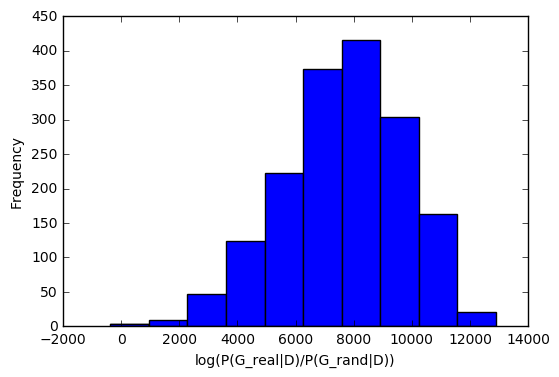

In [370]:
import matplotlib.pyplot
matplotlib.pyplot.hist(lp_real - lprobs_rand)
matplotlib.pyplot.xlabel("log(P(G_real|D)/P(G_rand|D))")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.show()